In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler


In [3]:
module = fc.eightb.preselection.t8btag_minmass


In [4]:
altfile = '{base}'
# altfile = 'feynnet_trgkin_mx_my_reweight_{base}'

# signal = ObjIter([])
signal = ObjIter([ Tree(f, altfile=altfile, report=False) for f in tqdm(module.feynnet_signal_list)])

# bkg = ObjIter([])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])

# data = ObjIter([])
data = ObjIter([Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile=altfile)])

100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


In [5]:
os.getpid()

109398

In [6]:
import multiprocess as mp
from functools import partial

# model = eightb.models.feynnet_trgkin_mx_my_reweight.analysis
model = eightb.models.feynnet_bkg_33sig.analysis
load_feynnet_assignment = eightb.f_load_feynnet_assignment(model)

# with mp.Pool(5) as pool:
#     (signal+bkg+data).parallel_apply( load_feynnet_assignment, report=True, pool=pool )

(signal+bkg+data).apply( load_feynnet_assignment, report=True )


100%|██████████| 36/36 [02:43<00:00,  4.54s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [7]:
def assign(tree):
    j = get_collection(tree, 'j', named=False)
    h = get_collection(tree, 'h', named=False)
    y = get_collection(tree, 'y', named=False)
    x = get_collection(tree, 'x', named=False)

    tree.extend(
        **{
            f'{J}_{field}': j[field][:,i]
            for field in j.fields
            for i, J in enumerate(eightb.quarklist)
        },
        **{
            f'{H}_{field}': h[field][:,i]
            for field in h.fields
            for i, H in enumerate(eightb.higgslist)
        },
        **{
            f'{Y}_{field}': y[field][:,i]
            for field in y.fields
            for i, Y in enumerate(eightb.ylist)
        },
        **{
            f'X_{field}': x[field]
            for field in x.fields
        }
    )
(signal+bkg+data).apply( assign, report=True )

100%|██████████| 36/36 [00:15<00:00,  2.38it/s]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [8]:
use_signal = [ i for i, mass in enumerate(signal.mass) if mass in ( '(800, 350)', '(1200, 450)', '(1200, 250)' ) ]

100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


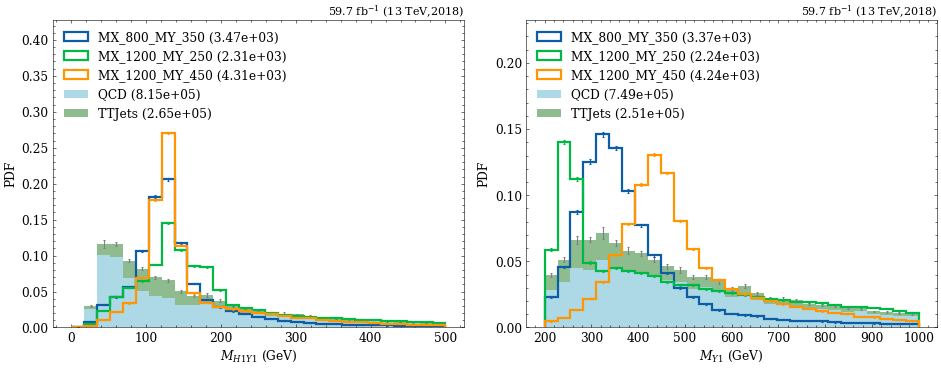

In [9]:
study.quick(
    signal[use_signal]+bkg,
    legend=True,
    varlist=['H1Y1_m', 'Y1_m'],
    efficiency=True,
)


In [10]:
@cache_variable(bins=(0,300,30))
def hm_chi(t):
    return np.sqrt( ak.sum((t.h_m-125)**2, axis=1) )

In [11]:
( signal+bkg+data ).apply(hm_chi, report=True)

100%|██████████| 36/36 [00:10<00:00,  3.60it/s]


[<Array [186, 240, 23.9, ... 294, 75.4, 65.4] type='51358 * float32'>, <Array [42.1, 171, 50.6, ... 70.3, 62.9, 23.5] type='53704 * float32'>, <Array [68.9, 56.2, 46.7, ... 292, 488, 14.1] type='64659 * float32'>, <Array [101, 134, 103, ... 32.7, 843, 60.3] type='43044 * float32'>, <Array [137, 56.8, 44.8, ... 272, 67.1, 73.7] type='50109 * float32'>, <Array [428, 149, 107, 371, ... 223, 286, 568] type='71933 * float32'>, <Array [28.1, 21.3, 369, ... 312, 31.3, 42.6] type='50121 * float32'>, <Array [101, 404, 60.3, ... 37.2, 60.2, 65.2] type='51292 * float32'>, <Array [48.8, 189, 13.7, ... 41.7, 61, 71.2] type='93725 * float32'>, <Array [103, 125, 77, 219, ... 81.4, 52, 78.7] type='77767 * float32'>, <Array [130, 38.8, 782, ... 105, 103, 63.1] type='52492 * float32'>, <Array [34.9, 59.2, 141, ... 529, 487, 58.7] type='111216 * float32'>, <Array [65.2, 31.9, 1.09e+03, ... 43.6, 23] type='56471 * float32'>, <Array [185, 1.36e+03, 74.8, ... 58.8, 38.8] type='104142 * float32'>, <Array [20

In [12]:
blinded = EventFilter('blinded', filter=lambda t :  ~ ((t.n_medium_btag > 4) & ( hm_chi(t) < 50 )) )
blinded_data = data.apply(blinded)

100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


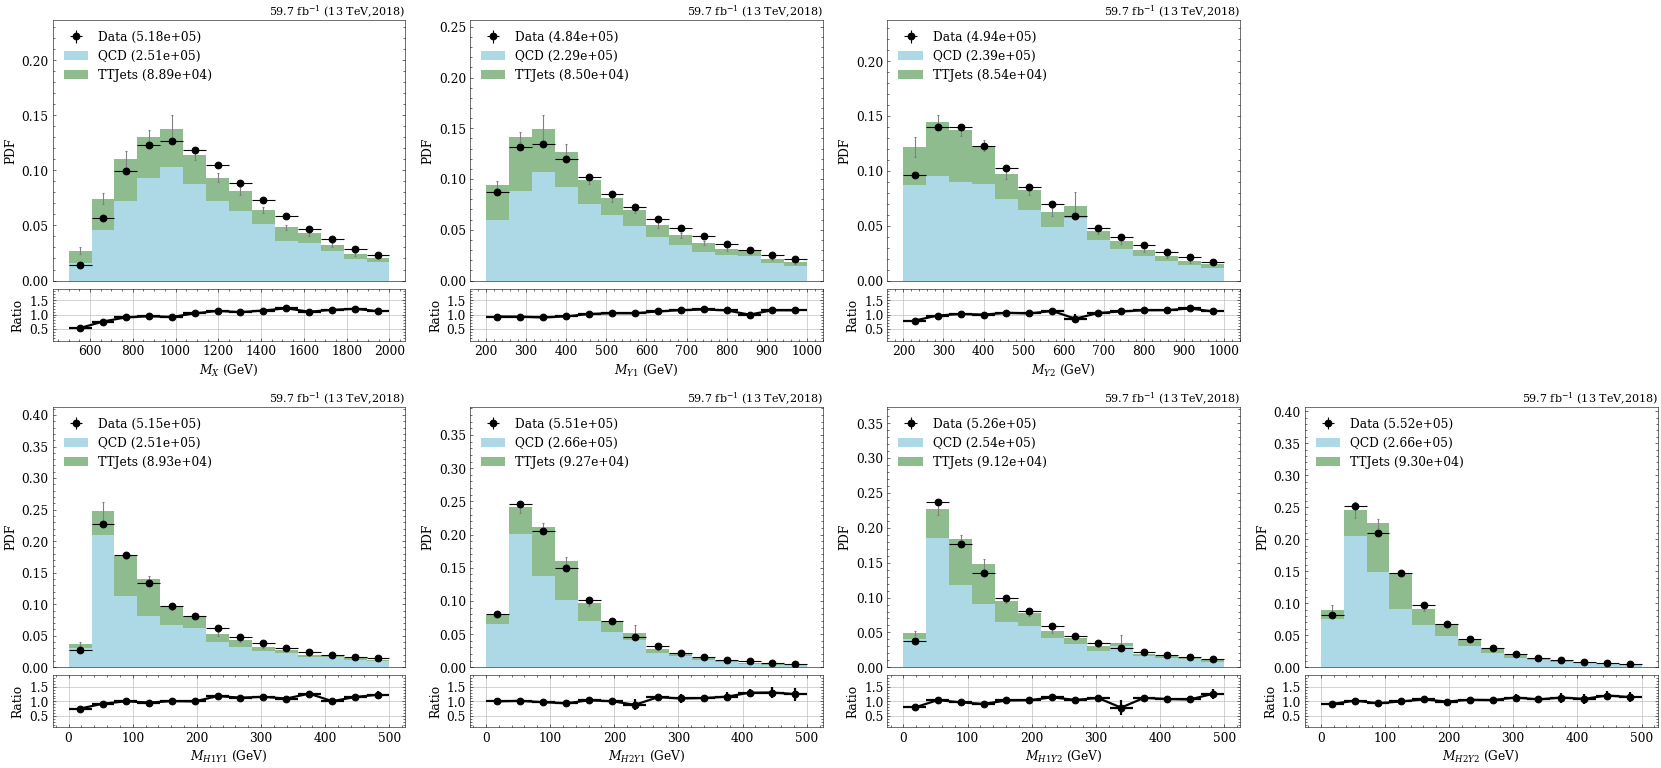

In [13]:
study.quick(
    blinded_data+bkg,
    masks=lambda t: t.n_medium_btag == 3,
    varlist=['X_m', 'Y1_m', 'Y2_m', None]+[f'{H}_m' for H in eightb.higgslist],
    efficiency=True,
    legend=True,
    h_rebin=15,
    ratio=True,
    # log=True,
)


In [14]:
varinfo.feynnet_maxscore = dict(bins=(-0.05,1.05,30))
varinfo.feynnet_minscore = dict(bins=(-0.05,1.05,30))


100%|██████████| 1/1 [00:15<00:00, 15.94s/it]


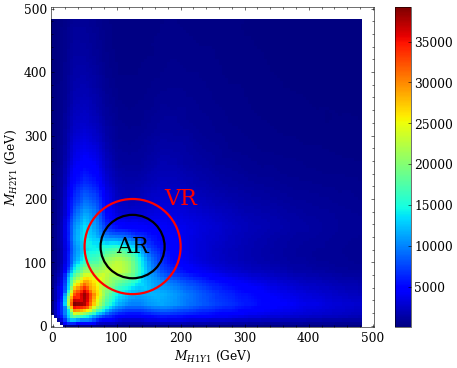

In [15]:
study.quick2d(
    blinded_data,
    varlist=['H1Y1_m','H2Y1_m'],
    binlist=[(0,500,30),(0,500,30)],
    interp=True,
    h_cmap='jet',
    # size=(5,10),
    colorbar=True,

    exe=[
        draw_circle(x=125,y=125,r=50, text=None, linewidth=2),
        lambda ax, **kwargs : ax.text(125, 125, 'AR', horizontalalignment='center', verticalalignment='center', fontsize=20),

        draw_circle(x=125,y=125,r=75, text=None, linewidth=2, color='red'),
        lambda ax, **kwargs : ax.text(200, 200, 'VR', horizontalalignment='center', verticalalignment='center', fontsize=20, color='red'),
    ],
)

In [16]:
bkg_model = blinded_data.asmodel()

In [17]:
bdt = ABCD(
    features=['feynnet_minscore']+[f'{res}_m' for res in eightb.scalarlist],
    a=lambda t : (t.n_medium_btag > 4) & ( hm_chi(t) < 50 ),
    b=lambda t : ((t.n_medium_btag == 4) | (t.n_medium_btag == 3)) & ( hm_chi(t) < 50 ),
    c=lambda t : (t.n_medium_btag > 4) & ( hm_chi(t) > 50 ),
    d=lambda t : ((t.n_medium_btag == 4) | (t.n_medium_btag == 3)) & ( hm_chi(t) > 50 ),
)

In [18]:
bdt.print_yields(bkg_model)

           --- ABCD model Yields ---            
Total: 7.61e+05 (29.00%)                        
SR   : 4.20e+04 (1.60%)                         
CR   : 7.19e+05 (27.40%)                        
------------------------------------------------
|           A          |           B           |
|       0.00e+00       |       4.20e+04        |
|        0.00%         |        1.60%          |
------------------------------------------------
|           C          |           D           |
|       2.82e+04       |       6.91e+05        |
|        1.08%         |        26.32%         |
------------------------------------------------


In [19]:
bdt.train(bkg_model)

... fetching features
... splitting features
... calculating k factor
... fitting reweighter


In [20]:
bdt.print_results(bkg_model)


--- ABCD Results ---
k = 4.084e-02
 (k*b)/a-1 = inf%
BDT(b)/a-1 = inf%



100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


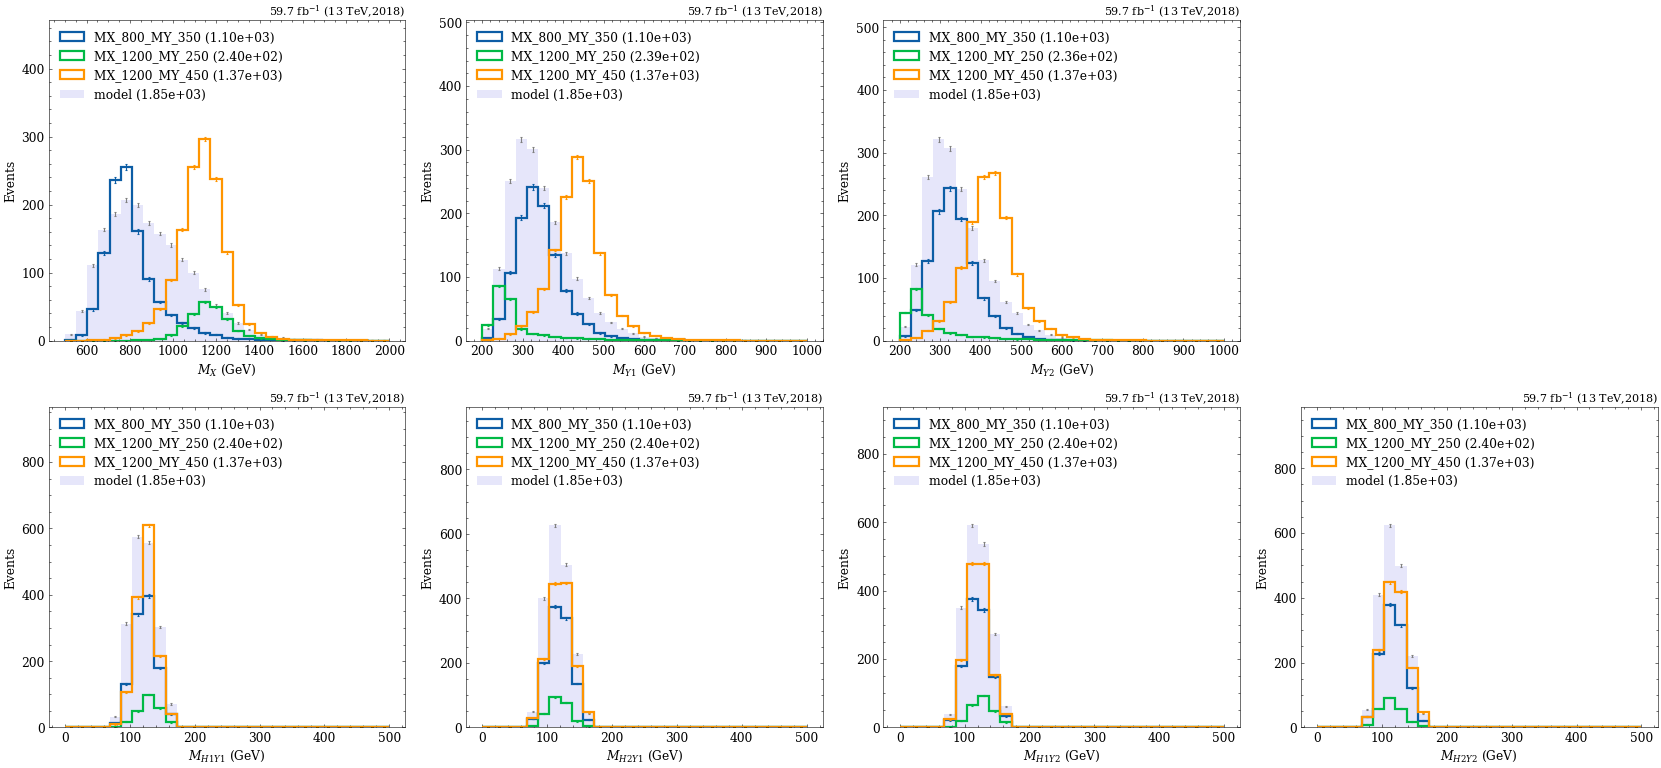

In [21]:
study.quick(
    signal[use_signal]+bkg_model,
    masks=[bdt.a]*len(use_signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(use_signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m', 'Y1_m', 'Y2_m', None]+[f'{H}_m' for H in eightb.higgslist],
    h_rebin=50,
    legend=True,
)


100%|██████████| 2/2 [00:15<00:00,  7.80s/it]


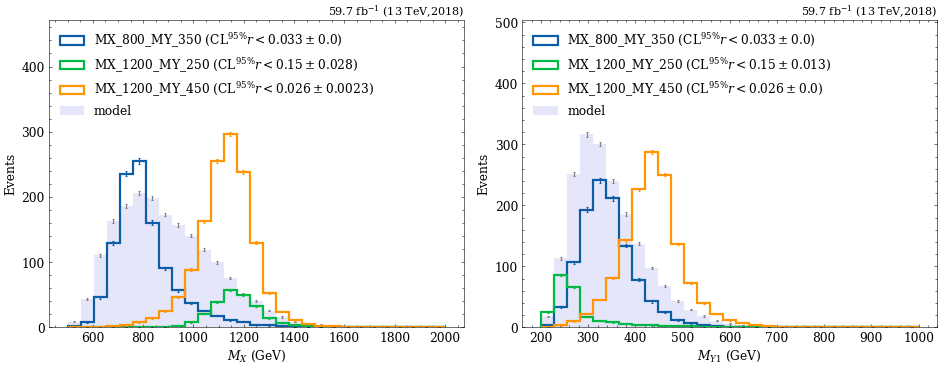

In [22]:
study.quick(
    signal[use_signal]+bkg_model,
    masks=[bdt.a]*len(use_signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(use_signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m', 'Y1_m'],
    h_rebin=50,
    legend=True,
    limits=True,
    l_parallel=True,
)


In [143]:

@cache_variable(bins=(0,1,30))
def flatten_mxmy(tree):
    mx_bins = np.linspace(0,2000,30)
    my_bins = np.linspace(0,1000,30)

    mx = np.digitize(tree.X_m, mx_bins)
    my1 = np.digitize(tree.Y1_m, my_bins)

    mxmy = len(my_bins)*mx + my1
    mxmy = mxmy/np.max(mxmy)
    return mxmy

In [144]:
import hilbert 
@cache_variable(bins=(0,1,30))
def hilbert_mxmy(tree):
    mx_bins = np.linspace(0,2000,30)
    my_bins = np.linspace(0,1000,30)

    mx = np.digitize(tree.X_m, mx_bins)
    my1 = np.digitize(tree.Y1_m, my_bins)

    mxmy = hilbert.encode(np.stack([mx, my1], axis=1).to_numpy(), 2, 32)
    mxmy = mxmy/(np.max(mxmy)+1)
    return mxmy

In [156]:
64/2

32.0

In [155]:
64/3

21.333333333333332

In [157]:
@cache_variable(bins=(0,1,30))
def hilbert_mxmy2(tree):
    mx_bins = np.linspace(0,2000,30)
    my_bins = np.linspace(0,1000,30)

    mx = np.digitize(tree.X_m, mx_bins)
    my1 = np.digitize(tree.Y1_m, my_bins)
    my2 = np.digitize(tree.Y2_m, my_bins)

    mxmy2 = np.stack([mx,my1, my2], axis=1).to_numpy()
    mxmy2 = hilbert.encode(mxmy2, 3, 20)
    mxmy2 = mxmy2/(np.max(mxmy2)+1)
    return mxmy2

In [159]:
(signal+bkg_model).apply(hilbert_mxmy2,report=True)







































































100%|██████████| 34/34 [01:30<00:00,  2.68s/it]


[<Array [0.0801, 0.509, ... 0.0809, 0.577] type='51358 * float64'>, <Array [0.0484, 0.0468, ... 0.0825, 0.0809] type='53704 * float64'>, <Array [0.0477, 0.0898, ... 0.746, 0.0909] type='64659 * float64'>, <Array [0.0467, 0.0486, ... 0.802, 0.083] type='43044 * float64'>, <Array [0.0853, 0.0815, ... 0.646, 0.948] type='50109 * float64'>, <Array [0.636, 0.392, 0.0867, ... 0.572, 0.569] type='71933 * float64'>, <Array [0.0804, 0.0805, ... 0.0881, 0.392] type='50121 * float64'>, <Array [0.0871, 0.811, ... 0.0895, 0.0892] type='51292 * float64'>, <Array [0.047, 0.397, ... 0.0917, 0.646] type='93725 * float64'>, <Array [0.713, 0.184, 0.198, ... 0.087, 0.821] type='77767 * float64'>, <Array [0.0887, 0.0444, ... 0.089, 0.077] type='52492 * float64'>, <Array [0.0851, 0.397, ... 0.605, 0.0873] type='111216 * float64'>, <Array [0.202, 0.0864, 0.79, ... 0.088, 0.0863] type='56471 * float64'>, <Array [0.819, 0.789, ... 0.0404, 0.0903] type='104142 * float64'>, <Array [0.599, 0.647, 0.825, ... 0.822

In [149]:
hilbert_mxmy.bins = (0,1,30)
flatten_mxmy.bins = (0,1,30)











100%|██████████| 4/4 [00:40<00:00, 10.01s/it]


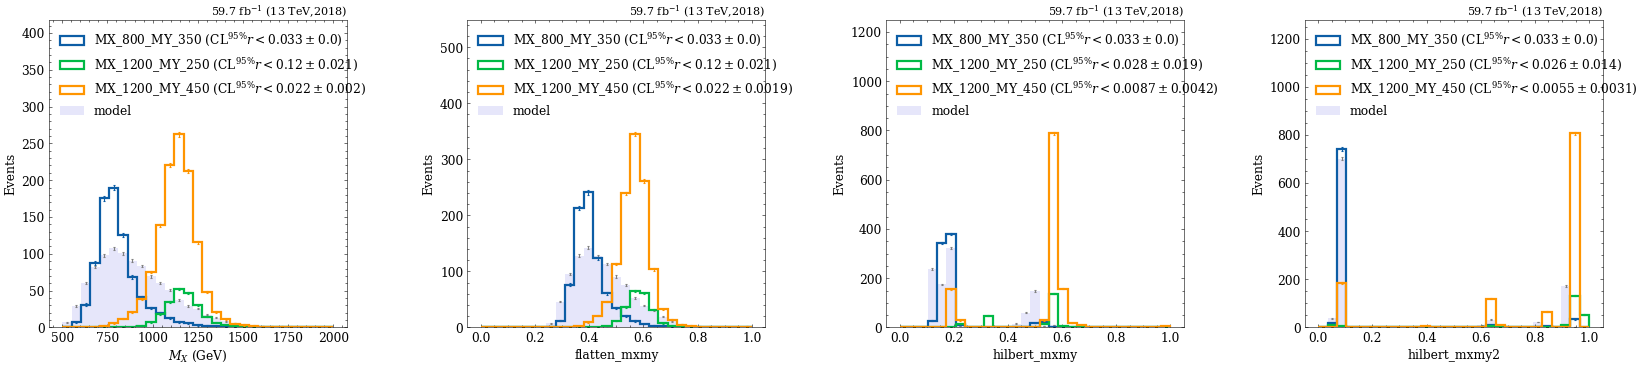

In [162]:
study.quick(
    signal[use_signal]+bkg_model,
    masks=[bdt.a]*len(use_signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(use_signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m',flatten_mxmy, hilbert_mxmy, hilbert_mxmy2],
    h_rebin=50,
    legend=True,
    limits=True,
    l_parallel=True,
    dim=-1,
)   

In [164]:
sig_mx_models = study.limits(
    signal+bkg_model,
    masks=[bdt.a]*len(signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'],
    h_rebin=50,
    poi=np.linspace(0,10,31),
)   













  0%|          | 0/34 [10:09<?, ?it/s]




  0%|          | 0/34 [10:12<?, ?it/s]






















100%|██████████| 33/33 [00:55<00:00,  1.68s/it]


In [163]:
sig_hilbert_mxmy2_models = study.limits(
    signal+bkg_model,
    masks=[bdt.a]*len(signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=[hilbert_mxmy2],
    binlist=[(0,1,50)],
    poi=np.linspace(0,10,31),
)   























  0%|          | 0/34 [08:14<?, ?it/s]


  0%|          | 0/34 [08:15<?, ?it/s]




  0%|          | 0/34 [08:16<?, ?it/s]


  0%|          | 0/34 [08:22<?, ?it/s]














100%|██████████| 33/33 [01:10<00:00,  2.15s/it]


In [126]:
sig_hilbert_mxmy_models = study.limits(
    signal+bkg_model,
    masks=[bdt.a]*len(signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=[hilbert_mxmy],
    binlist=[(0,1,50)],
    poi=np.linspace(0,10,31),
)   

100%|██████████| 33/33 [00:52<00:00,  1.59s/it]


In [127]:
sig_flatten_mxmy_models = study.limits(
    signal+bkg_model,
    masks=[bdt.a]*len(signal) + [bdt.b]*len(bkg_model),
    scale=[1]*len(signal) + [bdt.reweight_tree]*len(bkg_model),
    varlist=[flatten_mxmy],
    binlist=[(0,1,50)],
    poi=np.linspace(0,10,31),
)   

100%|██████████| 33/33 [01:05<00:00,  2.00s/it]


  0%|          | 0/34 [10:42<?, ?it/s]


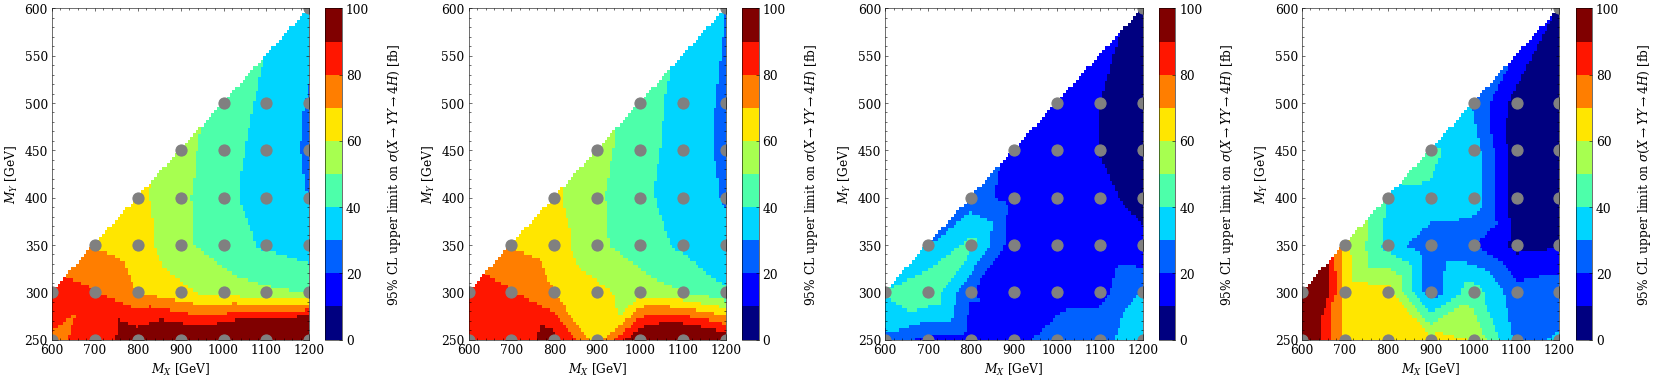

In [165]:
fig, axs = study.get_figax(4, dim=-1)

study.brazil2d_limits(
    sig_mx_models,
    zlim=np.linspace(0,100,11),
    g_cmap='jet',
    figax=(fig, axs[0])
)


study.brazil2d_limits(
    sig_flatten_mxmy_models,
    zlim=np.linspace(0,100,11),
    g_cmap='jet',
    figax=(fig, axs[1])

)

study.brazil2d_limits(
    sig_hilbert_mxmy_models,
    zlim=np.linspace(0,100,11),
    g_cmap='jet',
    figax=(fig, axs[2])
)
study.brazil2d_limits(
    sig_hilbert_mxmy2_models,
    zlim=np.linspace(0,100,11),
    g_cmap='jet',
    figax=(fig, axs[3])
)

fig.tight_layout()


In [166]:
vr_bdt = ABCD(
    features=['feynnet_minscore']+[f'{res}_m' for res in eightb.scalarlist],
    a=lambda t : (t.n_medium_btag > 4) & ( hm_chi(t) > 50 ) & ( hm_chi(t) < 75 ),
    b=lambda t : ((t.n_medium_btag == 4) | (t.n_medium_btag == 3)) & ( hm_chi(t) > 50 ) & ( hm_chi(t) < 75 ),
    c=lambda t : (t.n_medium_btag > 4) & ( hm_chi(t) > 75 ),
    d=lambda t : ((t.n_medium_btag == 4) | (t.n_medium_btag == 3)) & ( hm_chi(t) > 75 ),
)

In [167]:
vr_bdt.print_yields(bkg_model)

           --- ABCD model Yields ---            
Total: 7.39e+05 (28.17%)                        
SR   : 3.14e+04 (1.20%)                         
CR   : 7.08e+05 (26.98%)                        
------------------------------------------------
|           A          |           B           |
|       1.36e+03       |       3.00e+04        |
|        0.05%         |        1.14%          |
------------------------------------------------
|           C          |           D           |
|       2.77e+04       |       6.80e+05        |
|        1.06%         |        25.92%         |
------------------------------------------------


In [168]:
vr_bdt.train(bkg_model)

... fetching features
... splitting features
... calculating k factor
... fitting reweighter


In [169]:
vr_bdt.print_results(bkg_model)


--- ABCD Results ---
k = 4.079e-02
 (k*b)/a-1 = -10.24%
BDT(b)/a-1 = -2.60%



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


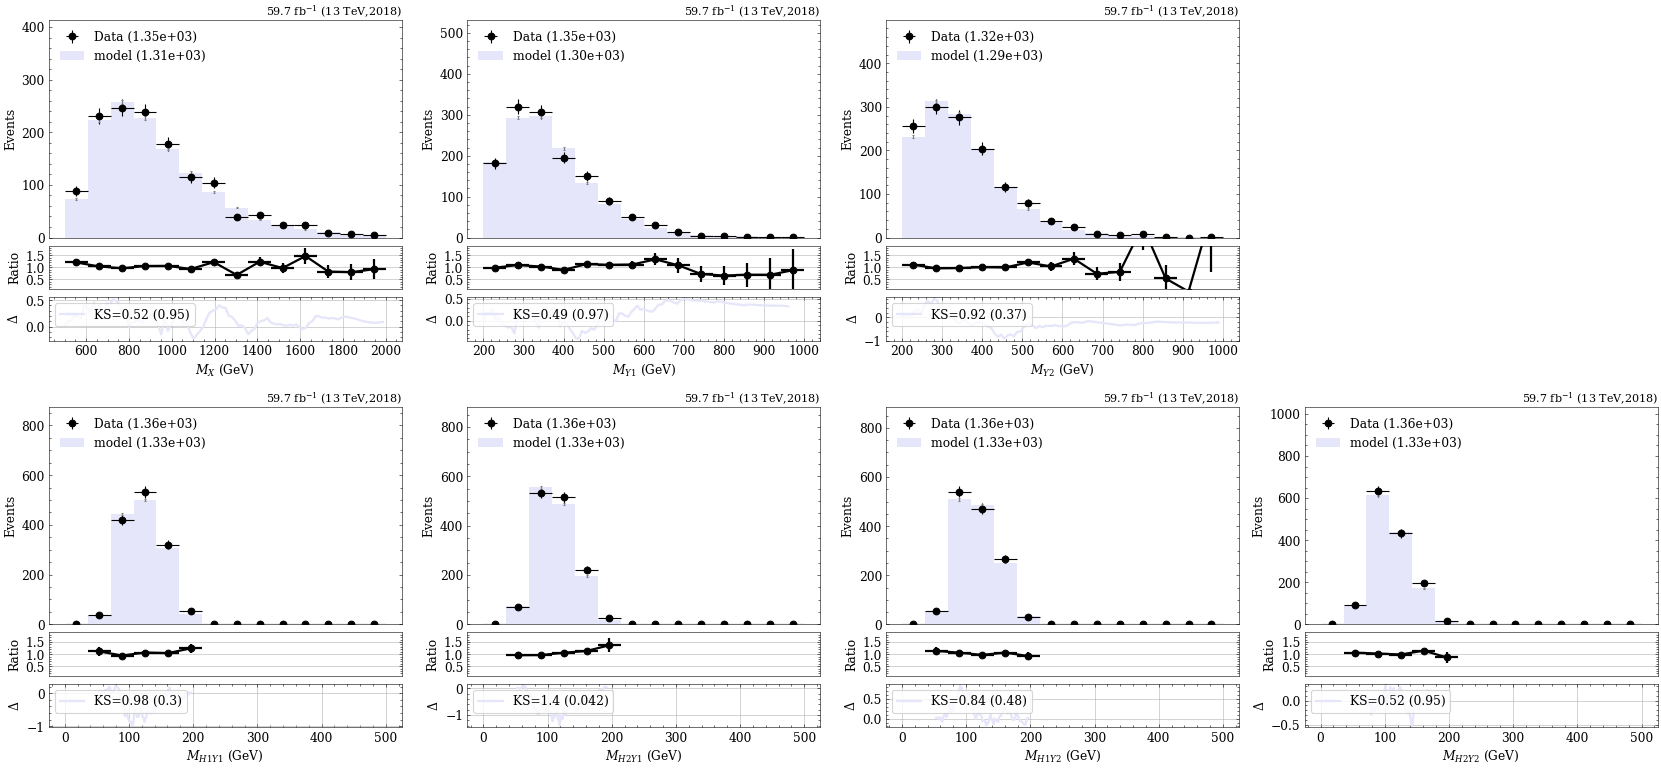

In [170]:
study.quick(
    blinded_data+bkg_model,
    masks=[vr_bdt.a]*len(blinded_data) + [vr_bdt.b]*len(bkg_model),
    scale=[1]*len(blinded_data) + [vr_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m', 'Y1_m', 'Y2_m', None]+[f'{H}_m' for H in eightb.higgslist],
    h_rebin=15,
    legend=True,

    ratio=True,
    **study.kstest,

)
